   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.3 MB/s eta 0:00:00
file already exists, skipping download
AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', '

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:22)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering


/tmp/ipython-input-1331798290.py:94: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


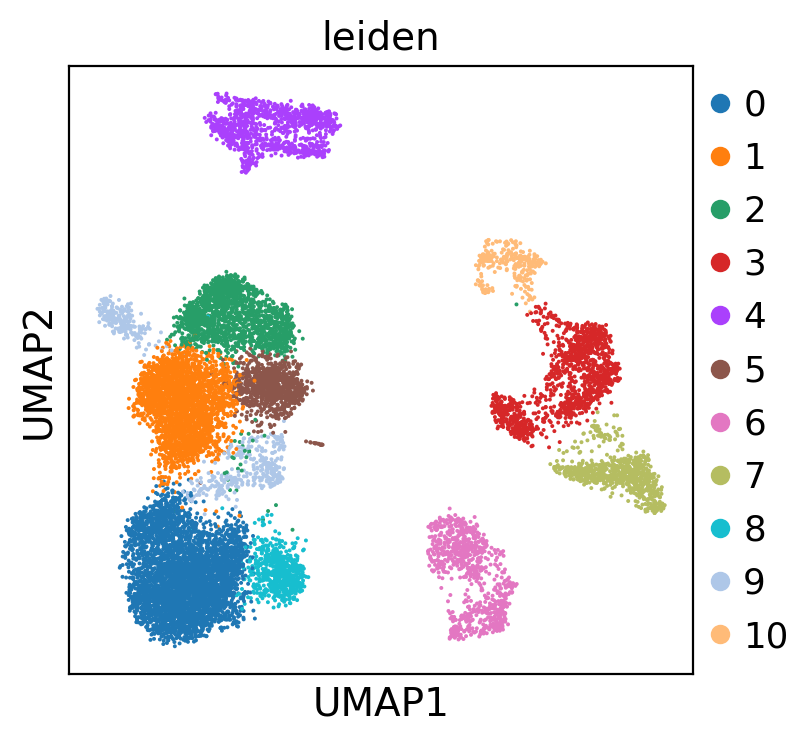

          source           target
0    Hepatocytes  ENSG00000148584
2  Bergmann glia  ENSG00000175899
4     Mast cells  ENSG00000128274
6   Interneurons  ENSG00000115977
7        Neurons  ENSG00000115977
processed data saved to bone_marrow)processed.h5ad


In [15]:
# ==========================
# Single‑Cell RNA‑Seq Analysis Pipeline
# Using Scanpy + Decoupler
# Dataset: Bone Marrow (.h5ad from GitHub)
# ==========================

import os
import urllib.request
import pandas as pd
import urllib.parse

# Install scanpy if not already installed
try:
    import scanpy as sc
except ImportError:
    !pip install scanpy
    import scanpy as sc

# Install decoupler if not already installed
try:
    import decoupler as dc
except ImportError:
    !pip install --upgrade --force-reinstall decoupler
    import decoupler as dc

# Install igraph for Leiden clustering if not already installed
try:
    import igraph
except ImportError:
    !pip install python-igraph

# Install leidenalg for Leiden clustering if not already installed
try:
    import leidenalg
except ImportError:
    !pip install leidenalg

#optional: plotting settings

sc.settings.verbosity=3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

#------------------
#1. Download the .h5ad file
#------------------

url="https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad"
out_file="bone_marrow.h5ad"
if not os.path.exists(out_file):
  print("downloading dataset...")
  urllib.request.urlretrieve(url, out_file)
  print("download complete:", out_file)
else:
  print("file already exists, skipping download")

#-------------------
#2. Load dataset
#-------------------
adata=sc.read_h5ad(out_file)
print(adata)

#-------------------
#3. Basic QC & Pre-processing
#-------------------

# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate percent MT if mitochondrial gene info exists, and filter
if any(adata.var_names.str.startswith('MT-')):
  adata.var['mt']=adata.var_names.str.startswith('MT-')
  sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
  adata=adata[adata.obs.n_genes_by_counts<5000,:]
  adata=adata[adata.obs.pct_counts_mt<10,:]

# Normalize & log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Scale data
sc.pp.scale(adata, max_value=10)

#-------------------
#4. Dimensionality reduction & clustering
#-------------------
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# Plot UMAP with Leiden clusters
sc.pl.umap(adata, color=['leiden'], save='_clusters.png')

#-------------------
#5. Prepare cell type markers (Ensembl mapping) via decoupler
#-------------------

# Download Ensembl ↔ gene symbol mapping
biomart_xml_query = (
    "<?xml version=\"1.0\" encoding=\"UTF-8\"?>"  # Fix by removing extra space before version
    "<!DOCTYPE Query><Query virtualSchemaName=\"default\" formatter=\"CSV\" header=\"0\" uniqueRows=\"0\" "
    "count=\"\" datasetConfigVersion=\"0.6\">"
    "<Dataset name=\"hsapiens_gene_ensembl\" interface=\"default\">"
    "<Attribute name=\"ensembl_gene_id\"/>"
    "<Attribute name=\"external_gene_name\"/>"
    "</Dataset></Query>"
)
biomart_url = "http://www.ensembl.org/biomart/martservice?query=" + urllib.parse.quote(biomart_xml_query)

mapping_file = "ensembl_mapping.txt"
if not os.path.exists(mapping_file):
    urllib.request.urlretrieve(biomart_url, mapping_file)
    print("downloaded ensembl mapping")

ensembl_var = pd.read_csv(mapping_file, header=None)
ensembl_var.columns = ["ensembl_gene_id", 'gene_name']

#Download panglaoDB markers
markers = dc.op.resource(name="PanglaoDB", organism="human")
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]

#Map gene symboles-Ensembl IDs
markers =markers.merge(
    ensembl_var,
    left_on="target",
    right_on="gene_name",
    how="left"
)
markers = markers.drop(columns=["target", "gene_name"])
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]
markers = markers.rename(columns={"ensembl_gene_id": "target"})
markers = markers[["source", "target"]]
markers = markers.dropna()

print(markers.head())

#8. Save Processed data
adata.write('bone_marrow_processed.h5ad')
print("processed data saved to bone_marrow)processed.h5ad")

In [18]:
#1 Cluster proportions
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
cluster_props = (cluster_counts / cluster_counts.sum()).round(3)
print(cluster_props.to_string())

#2 Top 8 Marker genes per cluster
import numpy as np
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', pts=True)
rg = adata.uns['rank_genes_groups']
groups = rg['names'].dtype.names if isinstance(rg['names'], np.ndarray) else list(rg['names'].dtype.names)
# safe printing for common scanpy versions:
for g in adata.obs['leiden'].cat.categories:
  names = rg['names'][g][:8]
  scores = rg['scores'][g][:8] if 'scores' in rg else ['NA']*len(names)
  print(f"cluster {g} top_markers: "+",".join(names))
  #3 Marker expression summary for key lineage markers
  key_markers = ['CD34','GATA1','KLF1','HBB','MPO','ELANE','CSF1R','IL1B','CD3D','CD4','CD8A','MS4A1','CD19','SDC1','MKI67','PF4','PPBP','GZMB','PRF1','NKG7']
  #Only keep markers present in var_names:
  # Map key_markers (gene symbols) to Ensembl IDs
  key_markers_ensembl = ensembl_var[ensembl_var['gene_name'].isin(key_markers)]['ensembl_gene_id'].tolist()
  print(f"DEBUG: Mapped Ensembl IDs for key_markers: {key_markers_ensembl}")
  markers_present = [m for m in key_markers_ensembl if m in adata.var_names]
  print(f"DEBUG: Markers present in adata: {markers_present}")
  import pandas as pd
  expr = pd.DataFrame(index=adata.obs['leiden'].cat.categories, columns=markers_present, dtype=float)
  for cl in expr.index:
    cells = adata.obs_names[adata.obs['leiden']==cl]
    expr.loc[cl] = adata[cells, markers_present].X.toarray().mean(axis=0) if hasattr(adata.X, "toarray") else adata[cells, markers_present].X.mean(axis=0)
    print(expr.round(3).to_string())

leiden
0     0.281
1     0.181
2     0.112
3     0.084
4     0.072
5     0.064
6     0.055
7     0.053
8     0.043
9     0.036
10    0.018
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:31)
cluster 0 top_markers: ENSG00000227507,ENSG00000168685,ENSG00000251562,ENSG00000109475,ENSG00000122026,ENSG00000126353,ENSG00000112306,ENSG00000213741
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3